In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import numpy as np

sns.set_style("whitegrid")
sns.set(font='serif')
sns.set_style("white", {
    "font.family": "serif",
    "font.serif": ["Times", "Palatino", "serif"],
})

In [2]:
def plot_results(df1, df2):
    unique_values1 = df1['model'].unique()
    unique_values2 = df2['model'].unique()

    resnet_results = df1[df1['model'] == unique_values1[0]]
    xception_results = df1[df1['model'] == unique_values1[1]]
    resnet_results2 = df2[df2['model'] == unique_values2[0]]
    xception_results2 = df2[df2['model'] == unique_values2[1]]

    fig, axes = plt.subplots(2, 2, figsize=(20, 10))  # Create a figure with four subplots

    x_min = .55
    x_max = .9

    for i, plot in enumerate([
        {"df": resnet_results, "model": "ResNet50", "ylabel": "In-Distribution"},
        {"df": xception_results, "model": "Xception", "ylabel": "In-Distribution"},
        {"df": resnet_results2, "model": "", "ylabel": "Out-of-Distribution"},
        {"df": xception_results2, "model": "", "ylabel": "Out-of-Distribution"}
    ]):
        params = {
            'legend.markerscale': 3,  # Font size of legend
        }
        plt.rcParams.update(params)

        ax = sns.pointplot(
            data=plot['df'],
            x='f1-score(weighted avg)',
            y='evaluation_set',
            hue='strategy',
            linestyles='none',
            errorbar=("ci", 95),
            dodge=.7,
            err_kws={'linewidth': 4},
            ax=axes[i//2, i%2]
        )

        ax.set_xlim(x_min, x_max)

        if i == 0 or i == 1:
            ax.set_xlabel("")
        else:
            ax.set_xlabel("F1-Score", fontsize=42)


        if i % 2 == 0:
            ax.set_ylabel(plot['ylabel'], fontsize=32)
            ax.set_yticklabels([])
        else:
            ax.set_yticklabels([])
            ax.set_ylabel("")

        ax.tick_params(labelsize=32)
        ax.set_title(plot['model'], fontsize=42 if plot['model'] else 0)

        ax.legend_.remove()

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, title="Strategy", loc='lower center', bbox_to_anchor=(0.5, -0.32), fontsize=42, title_fontsize=42, ncol=3)

    plt.tight_layout()
    plt.savefig('../output/aggregate_id_ood_plot.pdf', bbox_inches='tight')
    plt.show()

In [6]:
results = pd.read_csv(f'../results/full_10folds_results_all_severities.csv')

results_ood = results[results['evaluation_set'] != 'In-Distribution']
results_in = results[results['evaluation_set'] == 'In-Distribution']

In [7]:
def bootstrap_confidence_interval(data, num_samples=1000, ci=0.95):
    data = np.array(data)

    res = stats.bootstrap((data,), np.std, confidence_level=ci, n_resamples=num_samples, method='basic')
    return res.confidence_interval.low, res.confidence_interval.high

# In-Distribution Summary

In [8]:
grouped = results_in.groupby(['model', 'strategy'])
confidence_intervals = grouped['f1-score(weighted avg)'].apply(lambda x: bootstrap_confidence_interval(x.values))
average_fscore = grouped['f1-score(weighted avg)'].mean()

confidence_intervals_df = pd.DataFrame({
    'Model': confidence_intervals.index.get_level_values('model'),
    'strategy': confidence_intervals.index.get_level_values('strategy'),
    'F-Score 95%': [f"{avg:.4f} ({lower:.4f}, {upper:.4f})" for (avg, (lower, upper)) in zip(average_fscore, confidence_intervals)]
})

confidence_intervals_df

,Model,strategy,F-Score 95%
0,ResNet50,Baseline,"0.6638 (0.0502, 0.0869)"
1,ResNet50,DefaultAug,"0.8166 (0.0110, 0.0228)"
2,ResNet50,DefaultAug+Gaussian,"0.7962 (0.0102, 0.0241)"
3,ResNet50,DefaultAug+S&P,"0.7808 (0.0111, 0.0226)"
4,ResNet50,Gaussian,"0.6540 (0.0250, 0.0477)"
5,ResNet50,Salt&Pepper,"0.6525 (0.0232, 0.0429)"
6,Xception,Baseline,"0.7666 (0.0366, 0.0781)"
7,Xception,DefaultAug,"0.8610 (0.0043, 0.0106)"
8,Xception,DefaultAug+Gaussian,"0.8301 (0.0108, 0.0187)"
9,Xception,DefaultAug+S&P,"0.8242 (0.0127, 0.0256)"


-------

# Out of Distribution Summary

In [9]:
grouped = results_ood.groupby(['model', 'strategy'])
results_ood.loc[:, 'evaluation_set'] = 'ood'
confidence_intervals = grouped['f1-score(weighted avg)'].apply(lambda x: bootstrap_confidence_interval(x.values))
average_fscore = grouped['f1-score(weighted avg)'].mean()

confidence_intervals_df = pd.DataFrame({
    'Model': confidence_intervals.index.get_level_values('model'),
    'strategy': confidence_intervals.index.get_level_values('strategy'),
    'F-Score 95%': [f"{avg:.4f} ({lower:.4f}, {upper:.4f})" for (avg, (lower, upper)) in zip(average_fscore, confidence_intervals)]
})

confidence_intervals_df

,Model,strategy,F-Score 95%
0,ResNet50,Baseline,"0.5603 (0.1097, 0.1250)"
1,ResNet50,DefaultAug,"0.6947 (0.1061, 0.1258)"
2,ResNet50,DefaultAug+Gaussian,"0.7034 (0.1085, 0.1345)"
3,ResNet50,DefaultAug+S&P,"0.7180 (0.0890, 0.1160)"
4,ResNet50,Gaussian,"0.5642 (0.1096, 0.1295)"
5,ResNet50,Salt&Pepper,"0.5894 (0.0889, 0.1094)"
6,Xception,Baseline,"0.6244 (0.1165, 0.1305)"
7,Xception,DefaultAug,"0.7200 (0.1194, 0.1351)"
8,Xception,DefaultAug+Gaussian,"0.7529 (0.0895, 0.1170)"
9,Xception,DefaultAug+S&P,"0.7574 (0.0805, 0.1085)"


# Plots

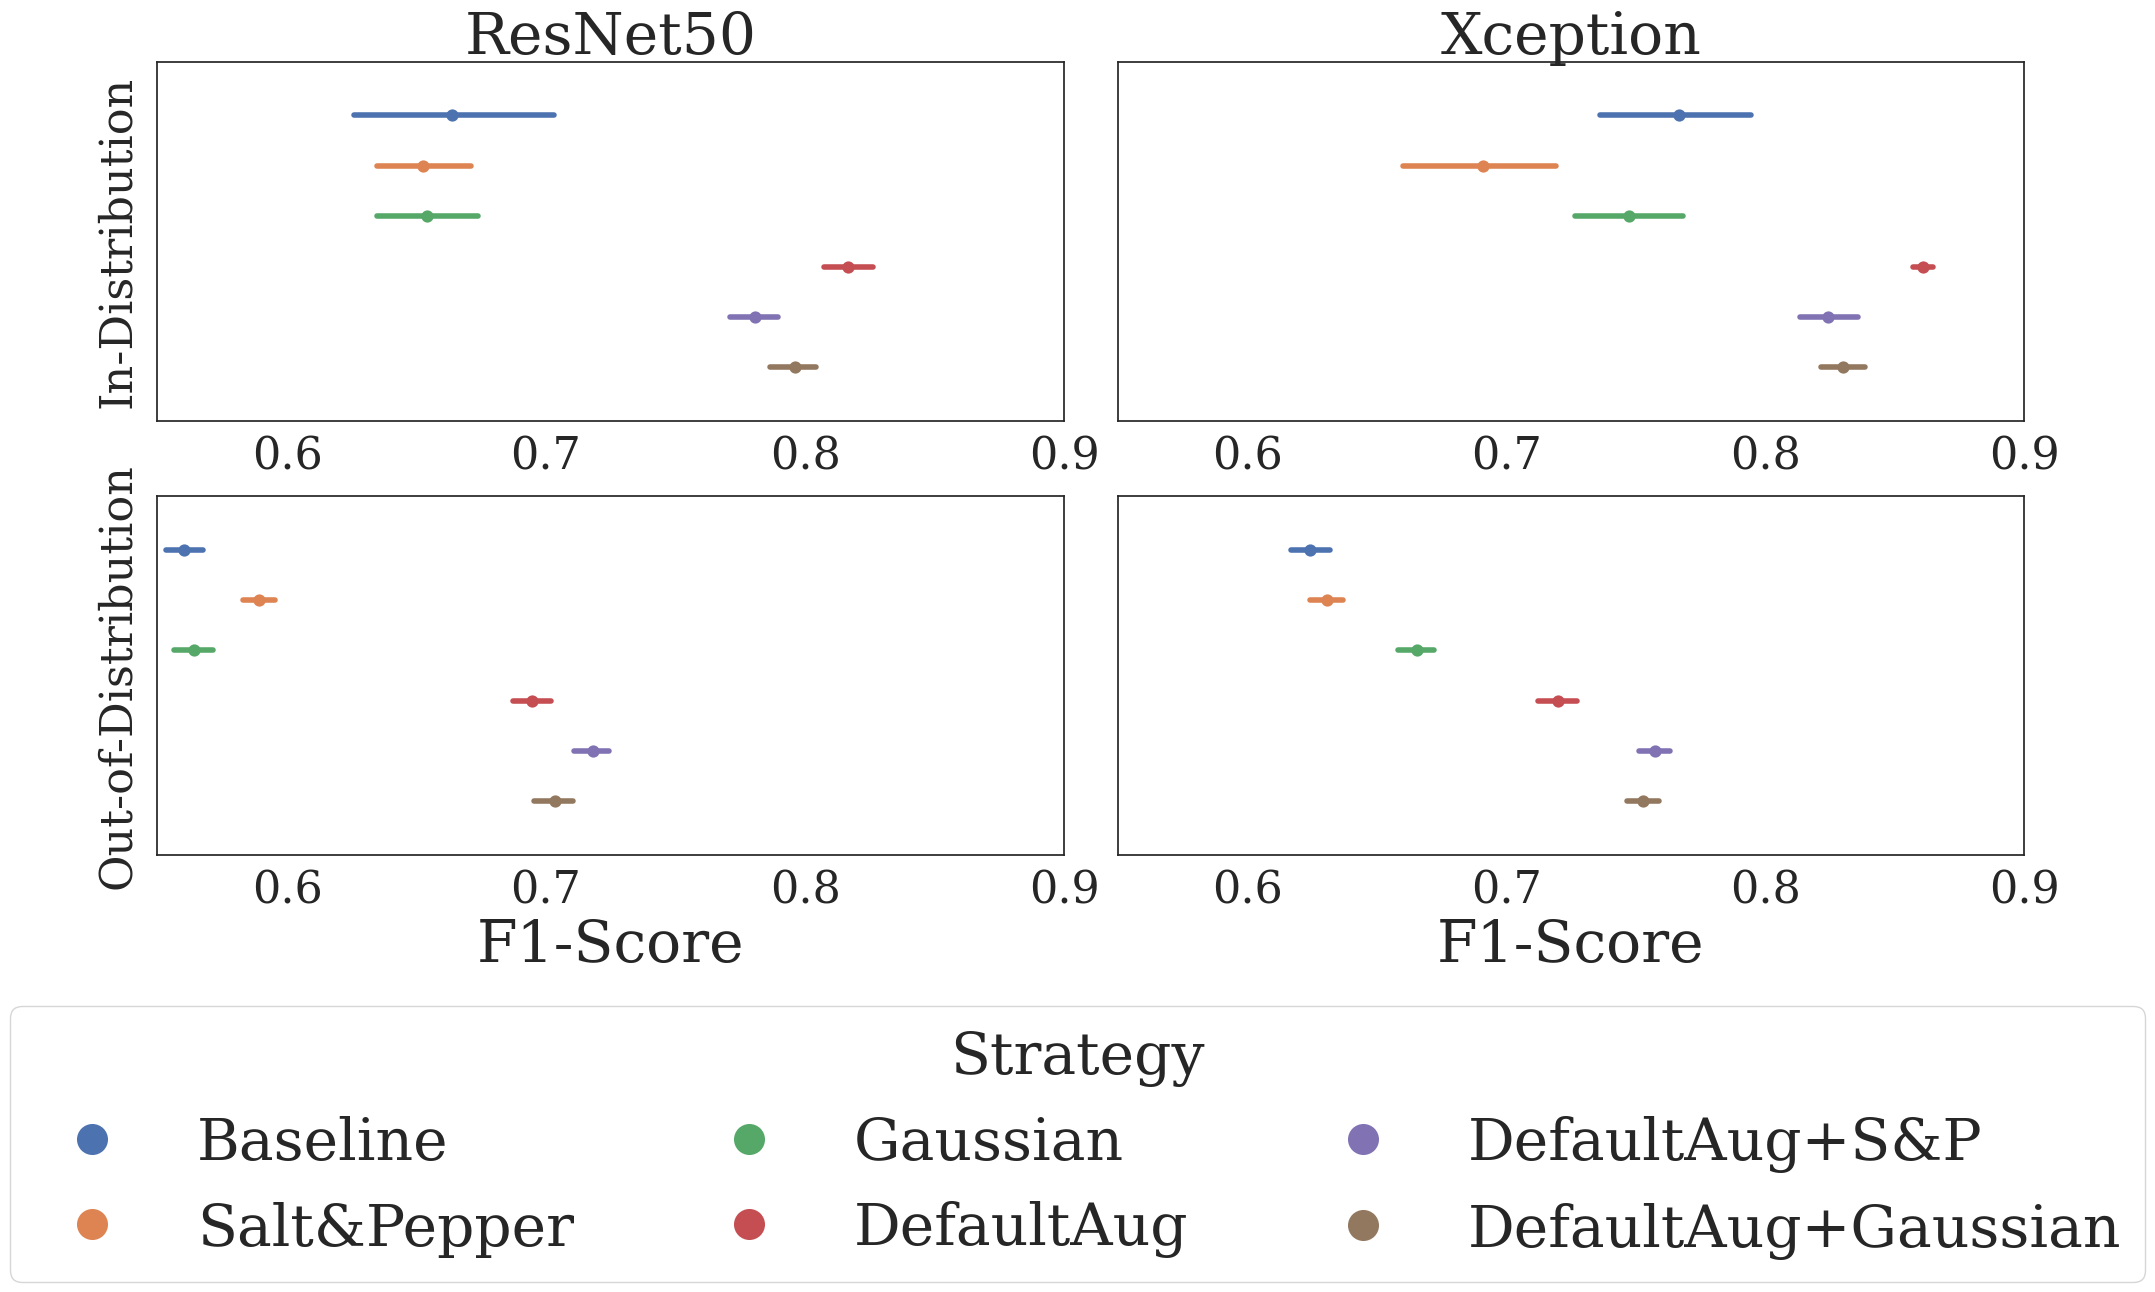

In [10]:
plot_results(results_in, results_ood)